Predicting the default rate of peer-to-peer loans 
====

### What is the question you hope to answer?

The goal of this project is to combine data on ratings & default rates of peer-to-peer loans arranged through Lending Club with publically available data on unemployment & housing costs to improve the prediction of default rates on these loans. 

Lending Club operates an online lending platform that enables borrowers to obtain a loan, and investors to purchase notes backed by payments made on loans. Lending Club is the world's largest peer-to-peer lending platform. 


Specifically, if I can identify positive or negative trends in unemployment and cost of living (rent), I hope that these will improve my ability to predict rate of return and/or the default rate compared to only using Lending Club's data.


### Available data

Lending Club publishes "complete loan data for all loans issued ", available for download as csv files. This includes information supplied about the borrower, amount of loan, loan grade, and loan purpose.

In addition, the data include information on the borrower's employment, living arrangement (rent/mortgage), & geographic location as well. 

I plan to take advantage of these items by combining them with data from 2 additional sources:

- Zillow publishes their data on both home values (ZHVI) and median rents (ZRI) by geographic area.

- The Bureau of Labor Statistics has published data on employment in multiple formats broken down by zip code & sector, [available as csv files](http://download.bls.gov/pub/time.series/overview.txt)

These data are available for download as csv files.



## Importing Lending Club data, 1st pass


In [1]:
import numpy as np
import pandas as pd

In [2]:
pwd

u'/Users/stephane/classes/ds2/repos/gadat-project'

In [3]:
#1st step - read in a sample of the data
path = 'data/lc/'
url = path + 'LoanStats3a.csv'
df = pd.read_csv(url,skiprows=[0, 39788,39789,39790, 42540, 42541, 42542, 42543])
dfc=df.columns

print list(dfc)
print len(dfc)
df.head(1)
print df.shape

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il

## Check a few items...

In [4]:
print "unique ids: {}".format(pd.value_counts(df.id).shape)
print "unique member_ids: {}".format(pd.value_counts(df.member_id).shape)

unique ids: (42535,)
unique member_ids: (42535,)


In [5]:
#loan_amnt doesn't always equal funded_amnt, but mostly does
adiff=df.loan_amnt - df.funded_amnt
print pd.value_counts(adiff).shape
pd.value_counts(adiff).head()

(519,)


0       40538
5000       16
7500       12
8000       11
3625       11
dtype: int64

In [6]:
colset1 = \
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
'loan_status', 
 'out_prncp', 'out_prncp_inv',
 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
 
]

In [7]:
df=df[colset1]

In [8]:
df.shape

(42535, 18)

## Using the loan 'grade' as a simplified feature

In [9]:
pd.value_counts(df.grade).sort_index()

A    10183
B    12389
C     8740
D     6016
E     3394
F     1301
G      512
Name: grade, dtype: int64

## Examine the 'loan_status' column - this is what we want to predict
### Was it a successful loan or not?
 - Use 'Fully Paid' & 'Current' loans as successful (1)
 - 'Charged Off' loans unsuccessful (0)

In [10]:
pd.value_counts(df.loan_status)

Fully Paid                                             32577
Charged Off                                             5605
Does not meet the credit policy. Status:Fully Paid      1988
Current                                                 1522
Does not meet the credit policy. Status:Charged Off      761
Late (31-120 days)                                        47
In Grace Period                                           27
Late (16-30 days)                                          7
Default                                                    1
Name: loan_status, dtype: int64

## Try a logistic regression model to predict loan success

In [11]:
#should look at df.grade, and see if that predicts df.loan_status
#treat loan_status as binary: 0 Charged Off; 1 Fully Paid (ignore others)
#convert grade to numeric
#first look at plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df2=df[(df.loan_status == 'Fully Paid') | (df.loan_status == 'Charged Off') | 
    (df.loan_status == 'Current')  ].copy()
df2['loan_status_num'] = df2.loan_status.map(
    {'Charged Off':0, 'Fully Paid':1, 'Current':1})
df2['grade_num'] = df2.grade.map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6})
df2.sort_values(by='grade_num',inplace=True)
gradenames=sorted(df.grade.unique())
gradenums = np.arange(0,7)

In [14]:
# fit a logistic regression model on entire dataset and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
feature_cols = ['grade_num']
X = df2[feature_cols]
y = df2.loan_status_num
logreg.fit(X, y)
df2['loan_status_pred_num'] = logreg.predict(X)

In [17]:
print type(X) , X.shape

<class 'pandas.core.frame.DataFrame'> (39704, 1)


In [18]:
# fit a logistic regression model using tts and store the class predictions
#from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=22)
logreg2 = LogisticRegression()
logreg2.fit(X_train,y_train)
y_pred_class = logreg2.predict(X_test)

## Plot predicted categories for test set

/Users/stephane/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


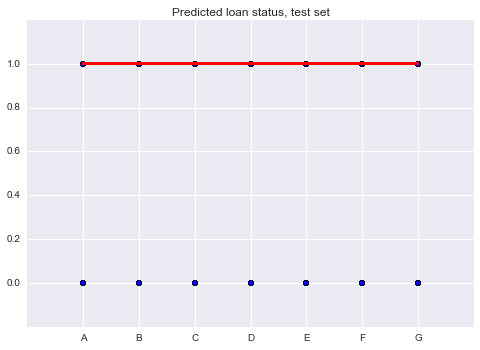

In [19]:
plt.scatter(df2.grade_num,df2.loan_status_num,label='loan status')
#plt.plot(df2.grade_num,df2.loan_status_pred_num,color='red')
plt.plot(X_test,y_pred_class,color='red')
plt.setp(plt.gca(), xticklabels=gradenames, xticks = gradenums)
plt.setp(plt.gca(), yticklabels=np.arange(0,1.2,.2), yticks = np.arange(0,1.2,.2))
plt.setp(plt.gca(),title = 'Predicted loan status, test set')

In [20]:
print metrics.accuracy_score(y_test, y_pred_class)
print metrics.accuracy_score(y_test,[1]*len(y_test))


0.855228692323
0.855228692323


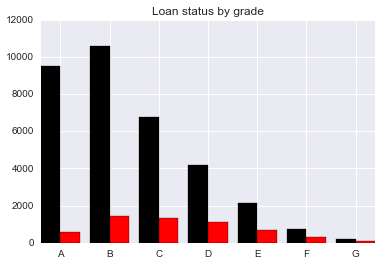

In [102]:
fig,ax = plt.subplots()
width=.4
xlocs=np.arange(0,7)
ax.bar(xlocs-width,grouped.loan_status_num.sum(),width,color='k')
ax.set_xticks(xlocs)
ax.set_xticklabels(sorted(df.grade.unique()))
ax.bar(
        xlocs,grouped.loan_status_num.apply(lambda item: (item == 0).sum()),width,
        color='r')
ax.set_title('Loan status by grade')

In [96]:
grouped=df2.groupby('grade')
probs=grouped.loan_status_num.sum()/grouped.loan_status_num.count()
print probs

grade
A    0.940301
B    0.881814
C    0.834444
D    0.790158
E    0.749295
F    0.698095
G    0.679365
Name: loan_status_num, dtype: float64


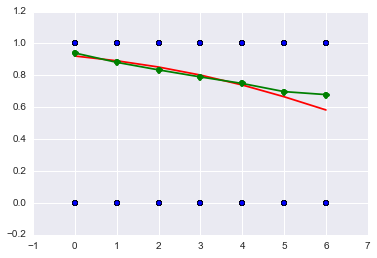

In [133]:
df2['loan_status_pred_prob']=logreg.predict_proba(X)[:,1]
plt.scatter(df2.grade_num,df2.loan_status_num)
#plt.plot(df2.grade_num,df2.loan_status_pred_prob,color='red')
X_test_s=X_test.sort_values(by='grade_num')
plt.plot(X_test_s,logreg2.predict_proba(X_test_s)[:,1],color='red')

plt.plot(probs,'go-')

### I've predicted probabilities based on probabilites.

## Next Steps:
- Retry model using other features
- Pull out housing cost data from Zillow, identify trends
- Merge with Lending Club data using zipcodes
- Try to improve the model using housing cost data